##Import necessary libraries

In [ ]:
%matplotlib inline


!cat /proc/cpuinfo # gives details of CPU

!nvidia-smi # gives details of GPU

# !pip uninstall tensorflow  #just incase you want to change version
# !pip install tensorflow==2.X.0
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model


# Commonly used modules
import numpy as np
import os, datetime
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)


from matplotlib.pyplot import imshow


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.148
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

##Load CIFAR100 dataset

In [ ]:
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test)  = cifar100.load_data()

# return the modified images
print("Train Images shape: ",x_train.shape)
print("Test Images shape: ",x_test.shape)
print(y_train.shape)
print(y_test.shape)

169001437/169001437 [==============================] - 6s 0us/step
Train Images shape:  (50000, 32, 32, 3)
Test Images shape:  (10000, 32, 32, 3)
(50000, 1)
(10000, 1)


##Preprocess Image Data

In [ ]:
def preprocess_images(X, Y): # should work for both a single image and multiple images
    X_p = keras.applications.densenet.preprocess_input(X)
    Y_p = keras.utils.to_categorical(Y, 100)
    return X_p, Y_p

# preprocess the train images
x_train, y_train = preprocess_images(x_train, y_train)

# preprocess the test images
x_test, y_test = preprocess_images(x_test, y_test)

##Baseline Model = VGG16
Images need to be resized to make the best use of the base model

In [14]:
from keras.applications.vgg16 import VGG16

# input tensor
inputs = keras.Input(shape=(32, 32, 3))

# upscale layer
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
            160,
            160,
            method=tf.image.ResizeMethod.BILINEAR))(inputs)

base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_tensor=upscale,
                   input_shape=(160,160,3),
                   pooling='max')

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 160, 160, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584

In [ ]:
## The head eg. fully connected network must be set up specific to this dataset
out = base_model.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

## Analysing Baseline Model

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs=inputs, outputs=out)

# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

Epoch 1/15
391/391 [==============================] - ETA: 0s - loss: 4.4795 - accuracy: 0.0295

391/391 [==============================] - 415s 948ms/step - loss: 4.4795 - accuracy: 0.0295 - val_loss: 4.7499 - val_accuracy: 0.0192
Epoch 2/15
391/391 [==============================] - ETA: 0s - loss: 4.1601 - accuracy: 0.0500

391/391 [==============================] - 327s 837ms/step - loss: 4.1601 - accuracy: 0.0500 - val_loss: 16.4471 - val_accuracy: 0.0265
Epoch 3/15
391/391 [==============================] - ETA: 0s - loss: 3.9997 - accuracy: 0.0643

391/391 [==============================] - 331s 846ms/step - loss: 3.9997 - accuracy: 0.0643 - val_loss: 4.1698 - val_accuracy: 0.0583
Epoch 4/15
391/391 [==============================] - ETA: 0s - loss: 3.8358 - accuracy: 0.0885

391/391 [==============================] - 330s 845ms/step - loss: 3.8358 - accuracy: 0.0885 - val_loss: 3.6894 - val_accuracy: 0.1177
Epoch 5/15
391/391 [==============================] - ETA: 0s - loss: 3.6919 - accuracy: 0.1119

391/391 [==============================] - 327s 838ms/step - loss: 3.6919 - accuracy: 0.1119 - val_loss: 256.2166 - val_accuracy: 0.0872
Epoch 6/15
391/391 [==============================] - ETA: 0s - loss: 3.5685 - accuracy: 0.1310

391/391 [==============================] - 329s 842ms/step - loss: 3.5685 - accuracy: 0.1310 - val_loss: 66.8859 - val_accuracy: 0.1467
Epoch 7/15
391/391 [==============================] - ETA: 0s - loss: 3.4434 - accuracy: 0.1506

391/391 [==============================] - 329s 842ms/step - loss: 3.4434 - accuracy: 0.1506 - val_loss: 3.6547 - val_accuracy: 0.1413
Epoch 8/15
391/391 [==============================] - ETA: 0s - loss: 3.3109 - accuracy: 0.1750

391/391 [==============================] - 329s 841ms/step - loss: 3.3109 - accuracy: 0.1750 - val_loss: 3.6470 - val_accuracy: 0.1527
Epoch 9/15
391/391 [==============================] - ETA: 0s - loss: 3.1936 - accuracy: 0.1956

391/391 [==============================] - 327s 837ms/step - loss: 3.1936 - accuracy: 0.1956 - val_loss: 3.4608 - val_accuracy: 0.1771
Epoch 10/15
391/391 [==============================] - ETA: 0s - loss: 3.0866 - accuracy: 0.2166

391/391 [==============================] - 329s 841ms/step - loss: 3.0866 - accuracy: 0.2166 - val_loss: 1375.0081 - val_accuracy: 0.2398
Epoch 11/15
391/391 [==============================] - ETA: 0s - loss: 2.9852 - accuracy: 0.2367

391/391 [==============================] - 329s 841ms/step - loss: 2.9852 - accuracy: 0.2367 - val_loss: 424.6422 - val_accuracy: 0.2612
Epoch 12/15
391/391 [==============================] - ETA: 0s - loss: 2.8937 - accuracy: 0.2527

391/391 [==============================] - 329s 841ms/step - loss: 2.8937 - accuracy: 0.2527 - val_loss: 2.9625 - val_accuracy: 0.2678
Epoch 13/15
391/391 [==============================] - ETA: 0s - loss: 2.8243 - accuracy: 0.2663

391/391 [==============================] - 328s 840ms/step - loss: 2.8243 - accuracy: 0.2663 - val_loss: 2207.4692 - val_accuracy: 0.2675
Epoch 14/15
391/391 [==============================] - ETA: 0s - loss: 2.7419 - accuracy: 0.2854

391/391 [==============================] - 326s 835ms/step - loss: 2.7419 - accuracy: 0.2854 - val_loss: 2.8467 - val_accuracy: 0.2954
Epoch 15/15
391/391 [==============================] - ETA: 0s - loss: 2.6634 - accuracy: 0.2991

391/391 [==============================] - 328s 839ms/step - loss: 2.6634 - accuracy: 0.2991 - val_loss: 2.6371 - val_accuracy: 0.3344


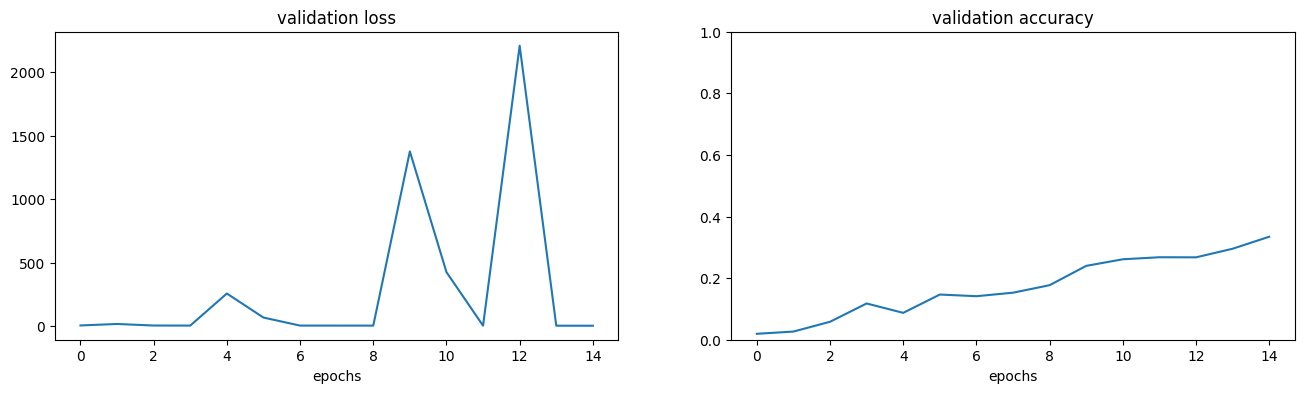

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Baseline_model_accuracy.png')

## Analysing Baseline Model with frozen backbone

https://keras.io/guides/transfer_learning/

In [23]:
# input tensor
inputs = keras.Input(shape=(32, 32, 3))

# upscale layer
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
            160,
            160,
            method=tf.image.ResizeMethod.BILINEAR))(inputs)

frozen_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_tensor=upscale,
                   input_shape=(160,160,3),
                   pooling='max')
# Might need to remove the pooling max to then compare against

In [24]:
frozen_model.trainable = False # freeze backbone

In [25]:
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`
x = frozen_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
x = frozen_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
# maybe change this to see if reducing no. of connected layers speeds up the training adn if the accuracy increases
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
# A Dense classifier with a 100 classes
outputs = keras.layers.Dense(100, activation='softmax')(x)

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

Epoch 1/15
391/391 [==============================] - ETA: 0s - loss: 3.7716 - accuracy: 0.1270

391/391 [==============================] - 117s 292ms/step - loss: 3.7716 - accuracy: 0.1270 - val_loss: 2.5897 - val_accuracy: 0.3446
Epoch 2/15
391/391 [==============================] - ETA: 0s - loss: 2.8292 - accuracy: 0.2640

391/391 [==============================] - 118s 301ms/step - loss: 2.8292 - accuracy: 0.2640 - val_loss: 2.2105 - val_accuracy: 0.4099
Epoch 3/15
391/391 [==============================] - ETA: 0s - loss: 2.5540 - accuracy: 0.3190

391/391 [==============================] - 121s 310ms/step - loss: 2.5540 - accuracy: 0.3190 - val_loss: 2.0689 - val_accuracy: 0.4443
Epoch 4/15
323/391 [=======================>......] - ETA: 17s - loss: 2.4150 - accuracy: 0.3522

In [1]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Frozen_Baseline_model_accuracy.png')

NameError: name 'plt' is not defined

Finetuning the model

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
history = model.fit(x=x_train, y=y_train, epochs=10, validation_data=(x_test, y_test))

##Test Model 1 = DenseNet121
Selected due to lower size and parameters than baseline model but higher top1 and top5 accuracy likely due to the depth of the Model.

In [ ]:
test_model1 = keras.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')

test_model1.summary()

In [ ]:
out = test_model1.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test1_model_accuracy.png')

##Test Model 2 = Xception

In [ ]:
test_model2 = keras.applications.Xception(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model2.summary()

In [ ]:
out = test_model2.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test2_model_accuracy.png')

## Test Model 3 = ResNet101

In [ ]:
test_model3 = keras.applications.ResNet101(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model3.summary()

In [ ]:
out = test_model3.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

NameError: name 'base_model' is not defined

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test3_model_accuracy.png')

##Test Model 4 = ResNet152

In [ ]:
test_model4 = keras.applications.ResNet152(include_top=False,
                                          weights='imagenet',
                                          input_tensor=upscale,
                                          input_shape=(160,160,3),
                                          pooling='max')

test_model4.summary()

In [ ]:
out = test_model4.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(100, activation='softmax')(out) #key change is that there are 100 output nodes for the 100 classes

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar100.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()
plt.savefig('Test3_model_accuracy.png')